In [1]:
#!pip install openpyxl
#!pip install scprotein

In [2]:
import scanpy as sc
import pandas as pd
import numpy as np
from openpyxl import Workbook, load_workbook
import re

sc.set_figure_params(dpi=80)

# Data loading

The data used in scPROTEIN is heavily processed and does not contain batch annotations, so in this notebook we extract the raw data and keep these missing annotations.

Datasets:
- NanoPOTS ✅ (👷)
- N2 ✅
- SCoPE2 leduc ⚠️
- plexDIA ✅
- pSCoPE huffman ⚠️
- pSCoPE leduc ❌


**Important**:
NanoPOTS uses Uniprot name, while N2 uses Uniprot ID for proteins. So the names don't match.

## NanoPOTS ✅ (👷)

> The nanoPOTS dataset was prepared by nanoPOTS technology. It quantifies ~~1225~~ 2331 proteins in ~~61~~ 72 cells (132 samples including booster, empty and references), which are composed of C10 cells, RAW cells and splenic vascular endothelial cells (SVECs).

Annotations:

- ✅ Cell type

- ✅ MS run

The input data used by scPROTEIN has been preprocessed as follows:

A.
> Contains the assembly of MSGF+ identifications and MASIC assemblies isotope corrected and sum rolled-up to the protein level. Contaminant and reverse hit were removed from this table.

B.
> Only the proteins with at least 2 unique peptides were conserved for further analysis the protein data was log2 transformed, filtered for outliers using the pmartR method (PMID: 30638385 ), median normalized, only proteins with at least 60% of values within a cell type were conserved for further analysis, the "sva::ComBat" function was used to remove TMT-set-dependent Batch effects. Paired two-tailed heteroscedastic T-tests were performed in order to establish protein enriched in a given condition and Z-scores were calculated for heatmap visualization.

They use the "Z-scores" as input for their models. 

We will use the data which has only undergone transformation A (and not also B). We also keep the TMT labels and log2 transform the data after step A.
We don't want to any of these preprocessing steps (except the log2 transform).


Raw data is available at [https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7192326/#SM1title](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7192326/#SM1title) (S4).

In [3]:
PATH = "data/raw/nanoPOTS/NIHMS1051229-supplement-S4.xlsx"

In [4]:
wb = load_workbook(PATH)

/home/rasmus/sollertis/work/ra/protvi/scPROTEIN/.conda/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)


In [5]:
ws = wb["01 - Raw sc protein data"]

In [6]:
# NOTE on data integration between NanoPOTS and N2:
# we could look up the uniprot ids from another excel sheet ("02 - Processed sc protein data") in the dataset.
# However, this sheet is for the processed protein data (imputed, batch corrected, z-scored) and 50% of the proteins have been removed. 
# So most of the proteins in our dataset will not have an annotation.

"""
ws_var = wb["02 - Processed sc protein data"]
data = ws.iter_rows(min_row=3, max_row=100, min_col=1, max_col=4, values_only=True)
rows = [v in data]

df = pd.DataFrame(rows, columns=["Uniprot_Name", "Uniprot_ID", "Description", "Corresponding bulk ProteinGroup Uniprot_IDs"])
"""

'\nws_var = wb["02 - Processed sc protein data"]\ndata = ws.iter_rows(min_row=3, max_row=100, min_col=1, max_col=4, values_only=True)\nrows = [v in data]\n\ndf = pd.DataFrame(rows, columns=["Uniprot_Name", "Uniprot_ID", "Description", "Corresponding bulk ProteinGroup Uniprot_IDs"])\n'

In [7]:
## vars

# protein names
c_protein = ws["A"]
protein = [c.value for c in c_protein[2:]]

# peptide counts
c_peptide_count = ws["B"]
peptide_count = [c.value for c in c_peptide_count[2:]]

# spectra counts
c_spectra_count = ws["C"]
spectra_count = [c.value for c in c_spectra_count[2:]]

var = pd.DataFrame({
    "protein": protein,
    "peptide_count": peptide_count,
    "spectra_count": spectra_count
})
var.set_index("protein", inplace=True)

In [8]:
## obs

c_cells = ws["D":"EE"]

cell_types = [c[0].value for c in c_cells]
id = [c[1].value for c in c_cells]

tmt_channel_size = 11 # includes "boost"
no_runs = len(cell_types) // tmt_channel_size
ms_runs = np.arange(no_runs).repeat(tmt_channel_size).astype(str)

obs = pd.DataFrame({
    "id": id,
    "cell_type": cell_types,
    "file_id": ms_runs
})
obs.set_index("id", inplace=True)

In [9]:
## data

ws_data = ws["D":"EE"]
X = np.array([[c.value for c in col[2:]] for col in ws_data])
X[X == "NA"] = np.nan
X = X.astype(float)

In [10]:
adata = sc.AnnData(X=X, obs=obs, var=var)
sc.pp.log1p(adata, base=2)
adata.layers["raw"] = adata.X.copy()

adata.X[np.isnan(adata.X)] = 0
sc.tl.pca(adata)

adata

AnnData object with n_obs × n_vars = 132 × 2331
    obs: 'cell_type', 'file_id'
    var: 'peptide_count', 'spectra_count'
    uns: 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'raw'

In [12]:
n_cells = np.sum(adata.obs["cell_type"].isin(["C10", "Raw", "SVEC"]))
print(f"Number of single-cells in the dataset: {n_cells}")

Number of single-cells in the dataset: 72


In [13]:
adata.write("data/processed/nanoPOTS.h5ad")

/home/rasmus/sollertis/work/ra/protvi/scPROTEIN/.conda/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/rasmus/sollertis/work/ra/protvi/scPROTEIN/.conda/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


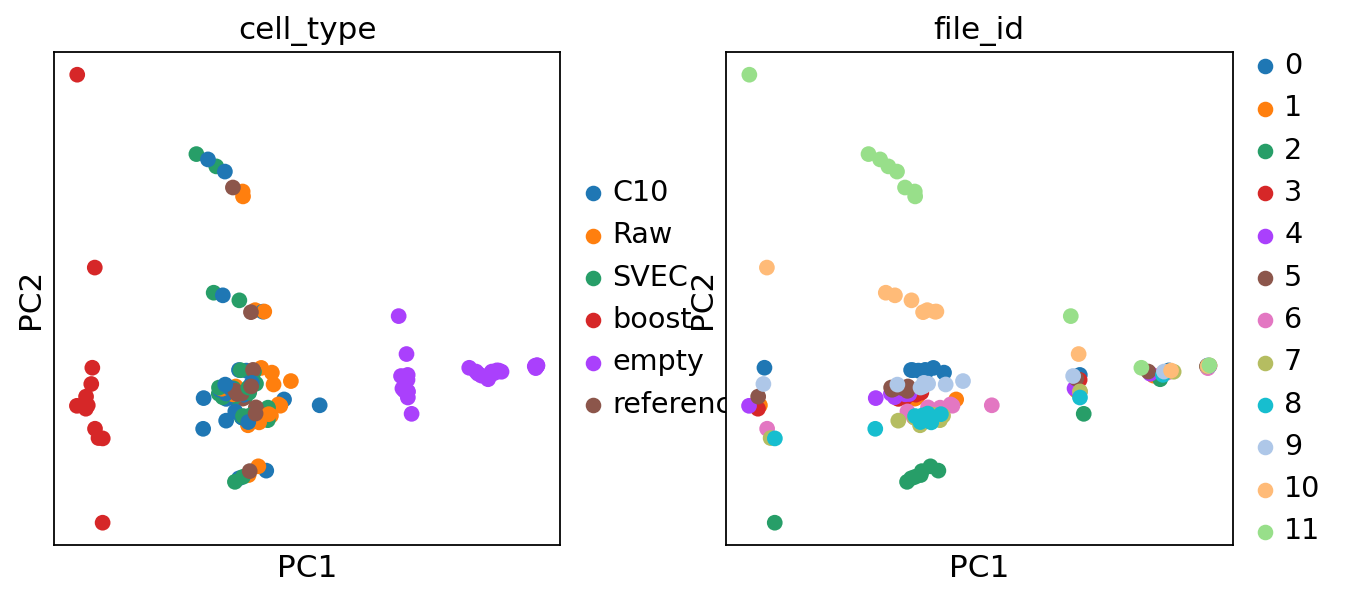

In [14]:
sc.pl.pca(adata, color=["cell_type", "file_id"], size=200)

/home/rasmus/sollertis/work/ra/protvi/scPROTEIN/.conda/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/rasmus/sollertis/work/ra/protvi/scPROTEIN/.conda/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


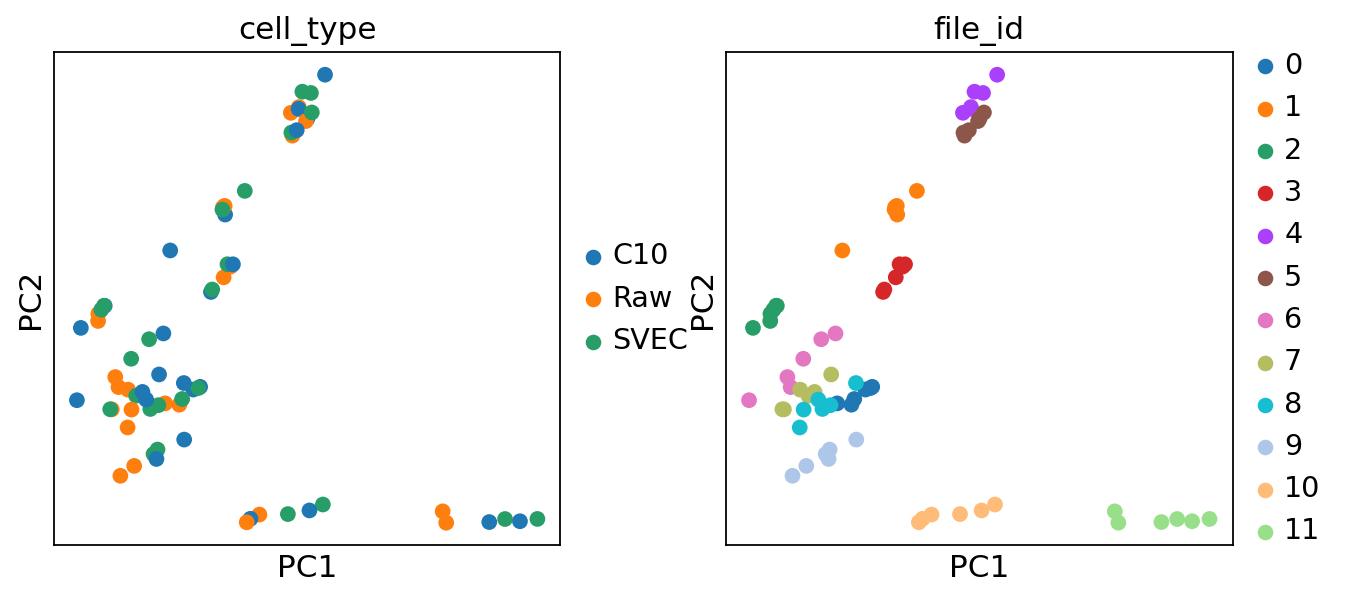

In [15]:
file_id = ["C10", "Raw", "SVEC"]
adata = adata[adata.obs["cell_type"].isin(file_id)]

sc.tl.pca(adata)
sc.pl.pca(adata, color=["cell_type", "file_id"], size=200)

Here is the data used by scPROTEIN:

In [16]:
adata = sc.read("../data_integration/integration_dataset/nanoPOTS.h5ad")

adata

AnnData object with n_obs × n_vars = 61 × 1225
    obs: 'cell_type'

/home/rasmus/sollertis/work/ra/protvi/scPROTEIN/.conda/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


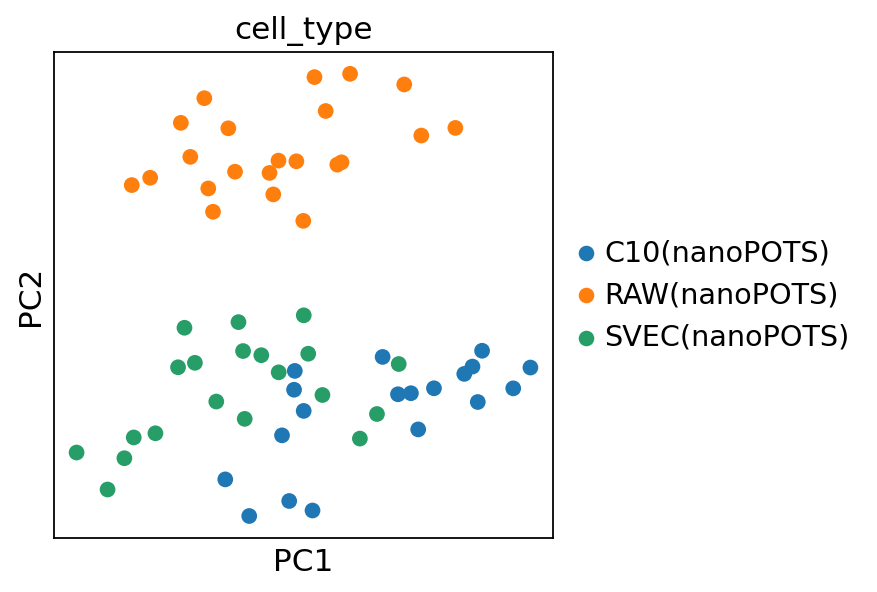

In [17]:
adata.X[np.isnan(adata.X)] = 0

sc.tl.pca(adata)
sc.pl.pca(adata, color=["cell_type"], size=200)

## N2 ✅

> The N2 dataset, which was sampled from mouse blood, contains 108 cells and ~~1068~~ 1437 proteins. This dataset contains three cell types (C10 cells, RAW cells and SVECs)


Annotations:

- ✅ Cell type

- ✅ MS run

- ✅ TMT channel

In [18]:
PATH = "data/raw/N2/Source_data_For main figures.xlsx"

In [19]:
wb = load_workbook(PATH)

In [20]:
ws = wb["Fig.4b"]

In [21]:
## vars

# protein ids
c_protein_ids = ws["A"]
protein_ids = [c.value for c in c_protein_ids[4:]]

# majority protein ids
c_protein_ids_majority = ws["B"]
protein_ids_majority = [c.value for c in c_protein_ids_majority[4:]]

# spectra counts
c_protein_names = ws["C"]
protein_names = [c.value for c in c_protein_names[4:]]

var = pd.DataFrame({
    "protein_ids": protein_ids,
    "protein_ids_majority": protein_ids_majority,
    "protein_names": protein_names
})
var.set_index("protein_ids_majority", inplace=True)

In [22]:
## obs

c_cells = ws["E":"DH"]

batch = [c[0].value for c in c_cells]
cell_types = [c[1].value for c in c_cells]
tmt_channel = [c[2].value for c in c_cells]
id = [c[3].value for c in c_cells]

obs = pd.DataFrame({
    "id": id,
    "cell_type": cell_types,
    "tmt_channel": tmt_channel,
    "file_id": batch,
})
obs.set_index("id", inplace=True)
obs["tmt_channel"] = obs["tmt_channel"].astype(str)
obs["file_id"] = obs["file_id"].astype(str)

In [23]:
## data

ws_data = ws["E":"DH"]

X = np.array([[c.value.split(";")[0] for c in col[4:]] for col in ws_data])
X[X == "NA"] = np.nan
X = X.astype(float)

In [24]:
adata = sc.AnnData(X=X, obs=obs, var=var)
adata.layers["raw"] = adata.X.copy()

adata.X[np.isnan(adata.X)] = 0
sc.tl.pca(adata)

adata

AnnData object with n_obs × n_vars = 108 × 1437
    obs: 'cell_type', 'tmt_channel', 'file_id'
    var: 'protein_ids', 'protein_names'
    uns: 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'raw'

In [25]:
adata.write("data/processed/N2.h5ad")

/home/rasmus/sollertis/work/ra/protvi/scPROTEIN/.conda/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/rasmus/sollertis/work/ra/protvi/scPROTEIN/.conda/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/rasmus/sollertis/work/ra/protvi/scPROTEIN/.conda/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


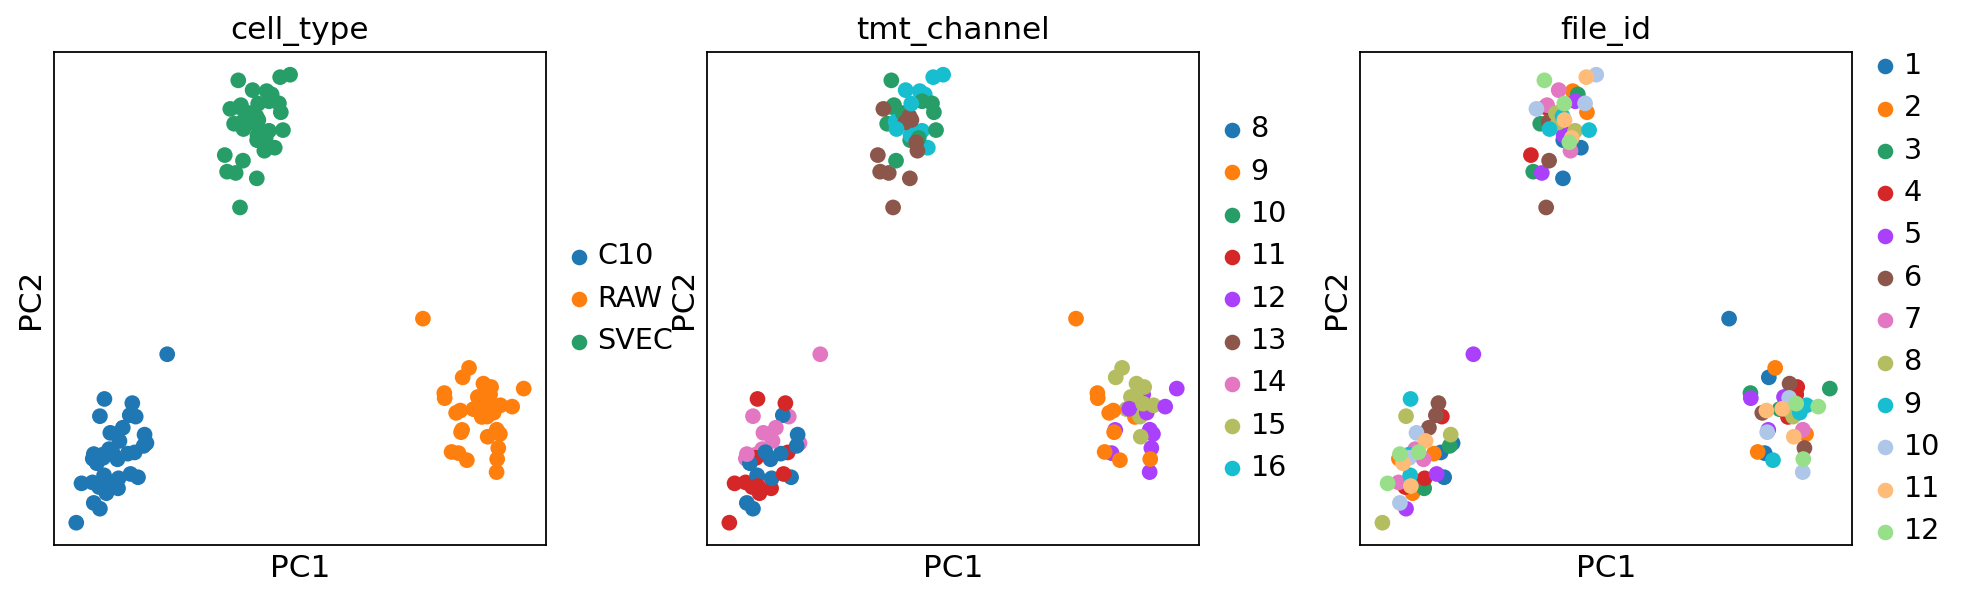

In [26]:
sc.pl.pca(adata, color=["cell_type", "tmt_channel", "file_id"], size=200)

Here is the data used by scPROTEIN:

In [27]:
adata = sc.read("../data_integration/integration_dataset/N2.h5ad")
adata

AnnData object with n_obs × n_vars = 108 × 1068
    obs: 'cell_type'

/home/rasmus/sollertis/work/ra/protvi/scPROTEIN/.conda/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


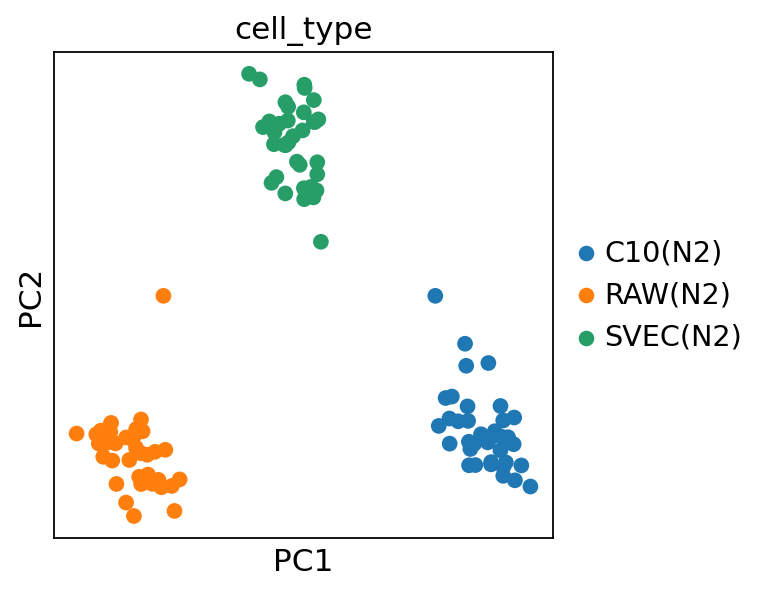

In [28]:
adata.X[np.isnan(adata.X)] = 0

sc.tl.pca(adata)
sc.pl.pca(adata, color=["cell_type"], size=200)

## SCoPE2 leduc ⚠️

Dataset contains 163 cells and 5270 peptides (1647 proteins) that were generated by SCoPE2. The dataset contains two cell types: HeLa cells and U-937 cells.

Annotations:

- ✅ Cell type

- ❌ MS run

Peptide data was acquired from [Leduc et al, 2021 data](https://scp.slavovlab.net/Leduc_et_al_2021):

- Peptides-raw.csv
- Cells.csv

In [29]:
PATH = "data/raw/SCoPE2_leduc/pep_proc.csv"

df_raw = pd.read_csv(PATH, index_col=0)
df_raw = df_raw.T

In [30]:
PATH = "data/raw/SCoPE2_leduc/anno.csv"

df_obs = pd.read_csv(PATH, index_col=0)
df_obs = df_obs.T
df_obs.rename(columns={"celltype": "cell_type"}, inplace=True)
df_obs.set_index("id", inplace=True)

In [31]:
df_obs["cell_type"][df_obs["cell_type"] == "H"] = "Hela"
df_obs["cell_type"][df_obs["cell_type"] == "U"] = "U-937"

In [32]:
df = df_raw.join(df_obs, how="inner")

In [33]:
obs_columns = ["cell_type"]
obs = df[obs_columns]

X = df.drop(obs_columns, axis=1)
var = pd.DataFrame(index=X.columns)
X = X.values

adata = sc.AnnData(X=X, obs=obs, var=var)
sc.pp.log1p(adata, base=2)
adata.layers["raw"] = adata.X.copy()

adata.X[np.isnan(adata.X)] = 0
sc.tl.pca(adata)

adata

/home/rasmus/sollertis/work/ra/protvi/scPROTEIN/.conda/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:351: RuntimeWarning: invalid value encountered in log1p
  np.log1p(X, out=X)


AnnData object with n_obs × n_vars = 163 × 5270
    obs: 'cell_type'
    uns: 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'raw'

In [34]:
adata.write("data/processed/SCoPE2_leduc.h5ad")

/home/rasmus/sollertis/work/ra/protvi/scPROTEIN/.conda/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


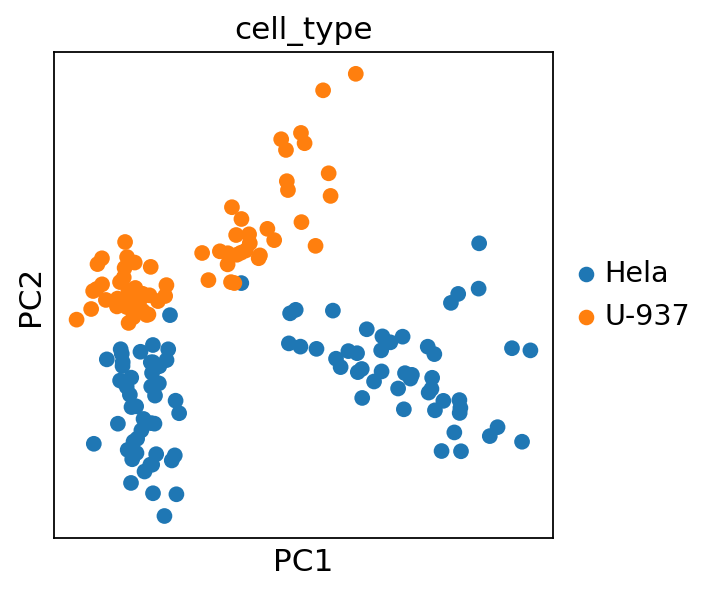

In [35]:
sc.pl.pca(adata, color=["cell_type"], size=200)

Here is the data used by scPROTEIN:

In [36]:
adata = sc.read("../data_integration/integration_dataset/SCoPE2_Leduc.h5ad")

adata

AnnData object with n_obs × n_vars = 163 × 1647
    obs: 'cell_type'

/home/rasmus/sollertis/work/ra/protvi/scPROTEIN/.conda/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


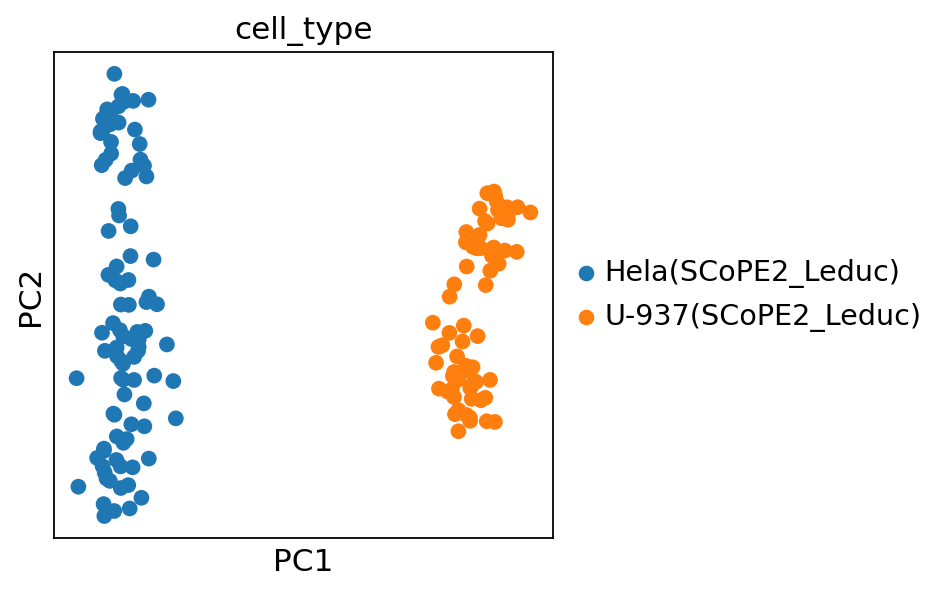

In [37]:
adata.X[np.isnan(adata.X)] = 0

sc.tl.pca(adata)
sc.pl.pca(adata, color=["cell_type"], size=200)

## plexDIA ✅

Precursor dataset contains ~~1,242 different proteins are quantified for 164 cells~~ 8721 precursors and 144 cells and three cell types: melanoma cells, U-937 cells and pancreatic ductal adenocarcinoma (PDAC (HPAFII)) cells.

Annotations:

- ✅ Cell type

- ✅ MS run

- (✅) Instrument (current we only load one of the dataset, i.e., one instrument. The code below supports loading both though!)

Extract from the original paper:
> PCA was performed on Ms1.Extracted timsTOF SCP single-cell data, Q Exactive single-cell data and Q Exactive 100-cell data. The following is a brief outline of the computational workflow. The abundance of each precursor was divided by the mean abundance of all three isotopologous precursors within the plexDIA set; then, the precursor of each labeled cell in each plexDIA was normalized to its median abundance; and then, each normalized precursor was divided by the mean of normalized precursor abundance across all labels and sets. These normalized precursor abundances were collapsed to protein group level by the median normalized abundance precursor. The protein group data were then normalized in the same way the precursors were normalized. Missing protein group data for each cell were imputed by k-nearest neighbors; the dataset was batch corrected for labels; and finally, a PCA was generated from the data. To increase the weights of proteins that are differentially abundant between the single cells in a coherent manner, we weighted each protein with the norm of its correlation vector (vector of pairwise correlations to all other proteins), as was previously described.


Precursor data was acquired from [Derks et al, 2022 data](https://scp.slavovlab.net/Derks_et_al_2022):

- wjD1146[...]tsvLib/Report.pr_matrix_channels.tsv
- nPOP[...]tsvLib/Report.pr_matrix_channels.tsv (we rename it to "nPOP_Report.pr_matrix_channels.tsv")
- Meta_SingleCell_updated_1.tsv

In [38]:
PATH = "data/raw/plexDIA/Report.pr_matrix_channels.tsv"

df_raw = pd.read_csv(PATH, sep="\t")

var = pd.DataFrame(index=df_raw.columns)

var_columns = df_raw.columns[:10]
var = df_raw[var_columns]
var.set_index("Precursor.Id", inplace=True)

X = df_raw.drop(var_columns, axis=1)
X.index = var.index

cell_ids = ["{}-{}".format(v.split("\\")[-1].split(".")[0], v[-1]) for v in X.columns]
X.columns = cell_ids

X_exactive = X.T
var_exactive = var

In [39]:
PATH = "data/raw/plexDIA/nPOP_Report.pr_matrix_channels.tsv"

df_raw = pd.read_csv(PATH, sep="\t")

var = pd.DataFrame(index=df_raw.columns)

var_columns = df_raw.columns[:10]
var = df_raw[var_columns]
var.set_index("Precursor.Id", inplace=True)

X = df_raw.drop(var_columns, axis=1)
X.index = var.index

cell_ids = ["{}-{}".format(v.split("\\")[-1].split(".")[0], v[-1]) for v in X.columns]
X.columns = cell_ids

X_timsTOF = X.T
var_timsTOF = var

In [40]:
X_timsTOF.index = X_timsTOF.index.str.extract(r"(Slot.*)", expand=False)

In [41]:
## NOTE: we only use the data acquired from Q-exactive.

"""
# to load both datasets (both instruments)

common_columns = X_exactive.columns.intersection(X_timsTOF.columns)
X = pd.concat([X_exactive[common_columns], X_timsTOF[common_columns]], axis=0)

var = pd.concat([var_exactive, var_timsTOF], axis=0)
var = var.loc[~var.index.duplicated(keep="first")]
var = var.loc[X.columns]
"""

X = X_exactive

In [42]:
PATH = "data/raw/plexDIA/Meta_SingleCell_updated_1.tsv"

df_obs = pd.read_csv(PATH, sep="\t")
df_obs.rename(columns={"Celltype": "cell_type"}, inplace=True)
#df_obs.rename(columns={"Raw": "file_id"}, inplace=True)

In [43]:
df_obs.index = ["{}-{}".format(raw, label).replace(".", "-") for raw, label in zip(df_obs["Raw"], df_obs["Label"])]

In [44]:
def renamer(x):
    if x.startswith("w"): 
        return x
    return re.search(r"(Slot.*)", x).group(0)

df_obs.index = df_obs.index.map(renamer)

In [45]:
df = X.join(df_obs, how="inner")

In [46]:
%%capture

obs = df[df_obs.columns]
obs.columns = obs.columns.str.lower()
obs["label"] = obs["label"].astype(str)

X = df.drop(df_obs.columns, axis=1)
var = pd.DataFrame(index=X.columns)
X  = X.values

In [47]:
adata = sc.AnnData(X=X, obs=obs, var=var)
sc.pp.log1p(adata, base=2)
adata.layers["raw"] = adata.X.copy()

adata.X[np.isnan(adata.X)] = 0
sc.tl.pca(adata)

adata

AnnData object with n_obs × n_vars = 144 × 8721
    obs: 'raw', 'instrument', 'lc_column', 'cell_type', 'label', 'set', 'real_single_cell', 'lcms_batch', 'sort_day', 'digest', 'id'
    uns: 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'raw'

In [48]:
adata.write("data/processed/plexDIA.h5ad")

/home/rasmus/sollertis/work/ra/protvi/scPROTEIN/.conda/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/rasmus/sollertis/work/ra/protvi/scPROTEIN/.conda/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/rasmus/sollertis/work/ra/protvi/scPROTEIN/.conda/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/rasmus/sollertis/work/ra/protvi/scPROTEIN/.conda/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


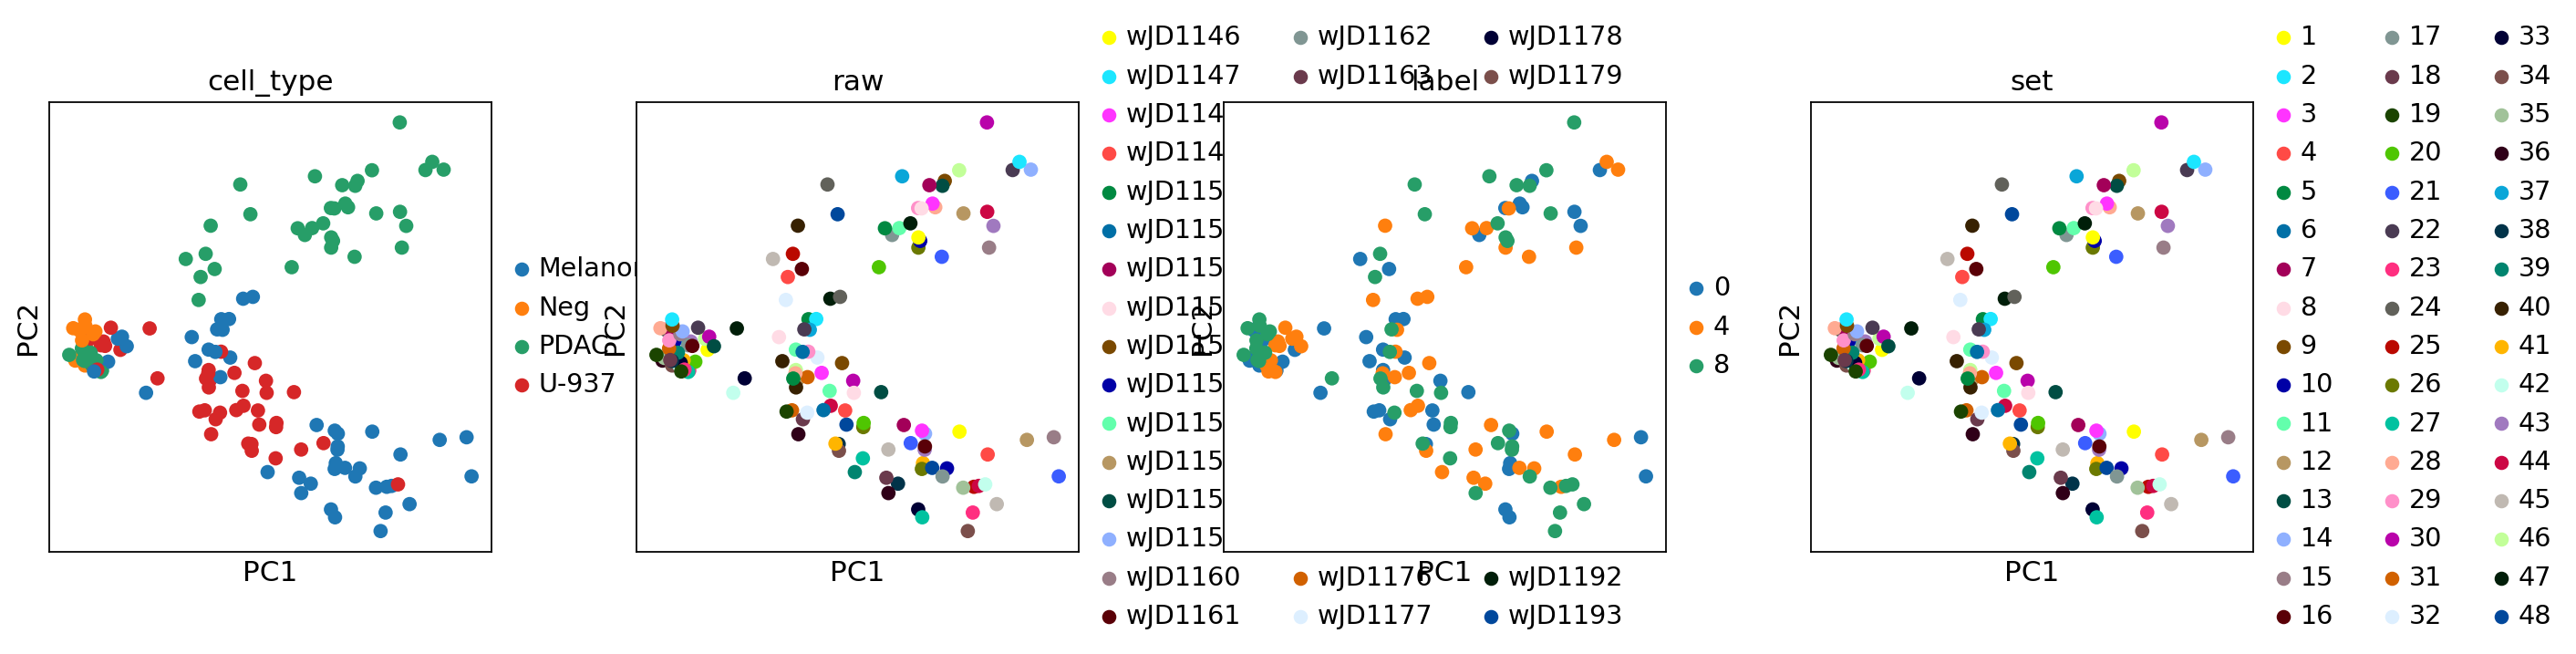

In [49]:
sc.pl.pca(adata, color=["cell_type", "raw", "label", "set"], size=200)

Here is the data used by scPROTEIN:

In [50]:
adata = sc.read("../data_integration/integration_dataset/plexDIA.h5ad")

adata

AnnData object with n_obs × n_vars = 164 × 1242
    obs: 'cell_type'

/home/rasmus/sollertis/work/ra/protvi/scPROTEIN/.conda/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


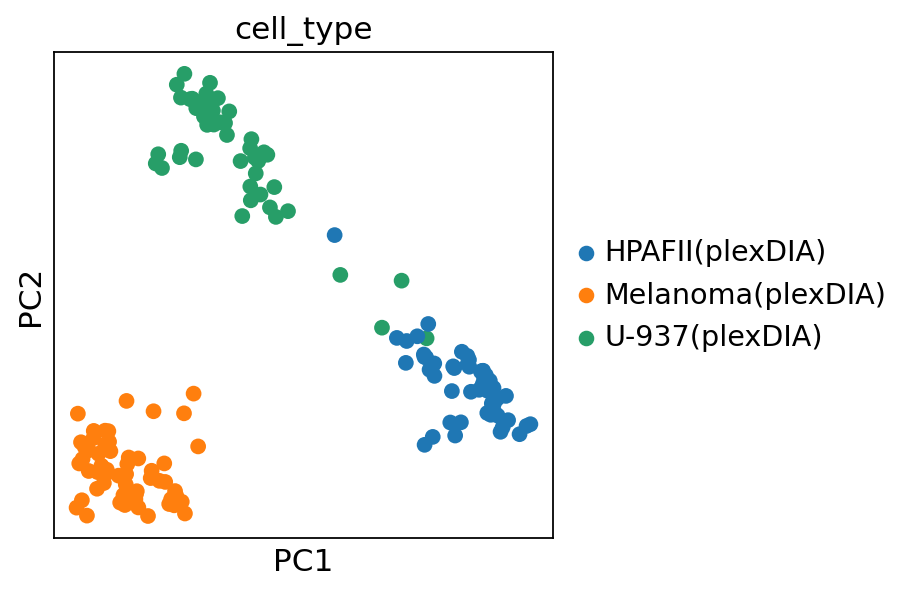

In [51]:
adata.X[np.isnan(adata.X)] = 0

sc.tl.pca(adata)
sc.pl.pca(adata, color=["cell_type"], size=200)

## pSCoPE Huffman ⚠️

Peptide dataset with 8341 peptides and 206 cells.

Annotations:

- ✅ Cell type

- ⚠️ MS run (is "Raw.file" the batch?)

Let's prepare the peptide data from [Huffman et al, 2022, version 1 data](https://scp.slavovlab.net/Huffman_et_al_2022_v1).
We use the following two files:

Under "Benchmarking experiments: Figure 1b/e data"
- [Peptides-raw.csv](https://drive.google.com/file/d/1gbbn_SgwaPYAYG3iiQqpEHSw34hpKp5M/view)
- [Cells.csv](https://drive.google.com/file/d/1J7sBHYwo5669w8igY4ldojPcLwuqX7I-/view)

In [52]:
PATH = "data/raw/pSCoPE_Huffman/peptidesRaw_PDAC_Coverage_PIF50_mrri10.txt"

df_raw_data = pd.read_csv(PATH, sep="\t")

var_columns = ["protein", "peptide"]
var = df_raw_data[var_columns]
var.set_index("peptide", inplace=True)

df_raw_data = df_raw_data.drop(columns=var_columns)
df_raw_data = df_raw_data.T.copy()

df_raw_data.shape

(206, 8341)

In [53]:
PATH = "data/raw/pSCoPE_Huffman/PDAC_Coverage_SampleGuide.csv"

df_obs = pd.read_csv(PATH)
df_obs.rename(columns={"Raw.file": "file_id"}, inplace=True)
df_obs.set_index("id", inplace=True)
df_obs.rename(columns={"celltype": "cell_type"}, inplace=True)

In [54]:
df = df_raw_data.join(df_obs, how="inner")

obs = df[df_obs.columns]
df.drop(columns=df_obs.columns, inplace=True)

In [55]:
X = df.values

obs.index = np.arange(len(obs))
obs.index = obs.index.astype(str)

adata = sc.AnnData(X=X, obs=obs, var=var)
adata.layers["raw"] = adata.X.copy()

adata.X[np.isnan(adata.X)] = 0
sc.tl.pca(adata)

adata

AnnData object with n_obs × n_vars = 206 × 8341
    obs: 'RI', 'file_id', 'cell_type', 'lcbatch', 'sortday', 'digest', 'cvm'
    var: 'protein'
    uns: 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'raw'

In [56]:
adata.write("data/processed/pSCoPE_huffman.h5ad")

/home/rasmus/sollertis/work/ra/protvi/scPROTEIN/.conda/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/rasmus/sollertis/work/ra/protvi/scPROTEIN/.conda/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/rasmus/sollertis/work/ra/protvi/scPROTEIN/.conda/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


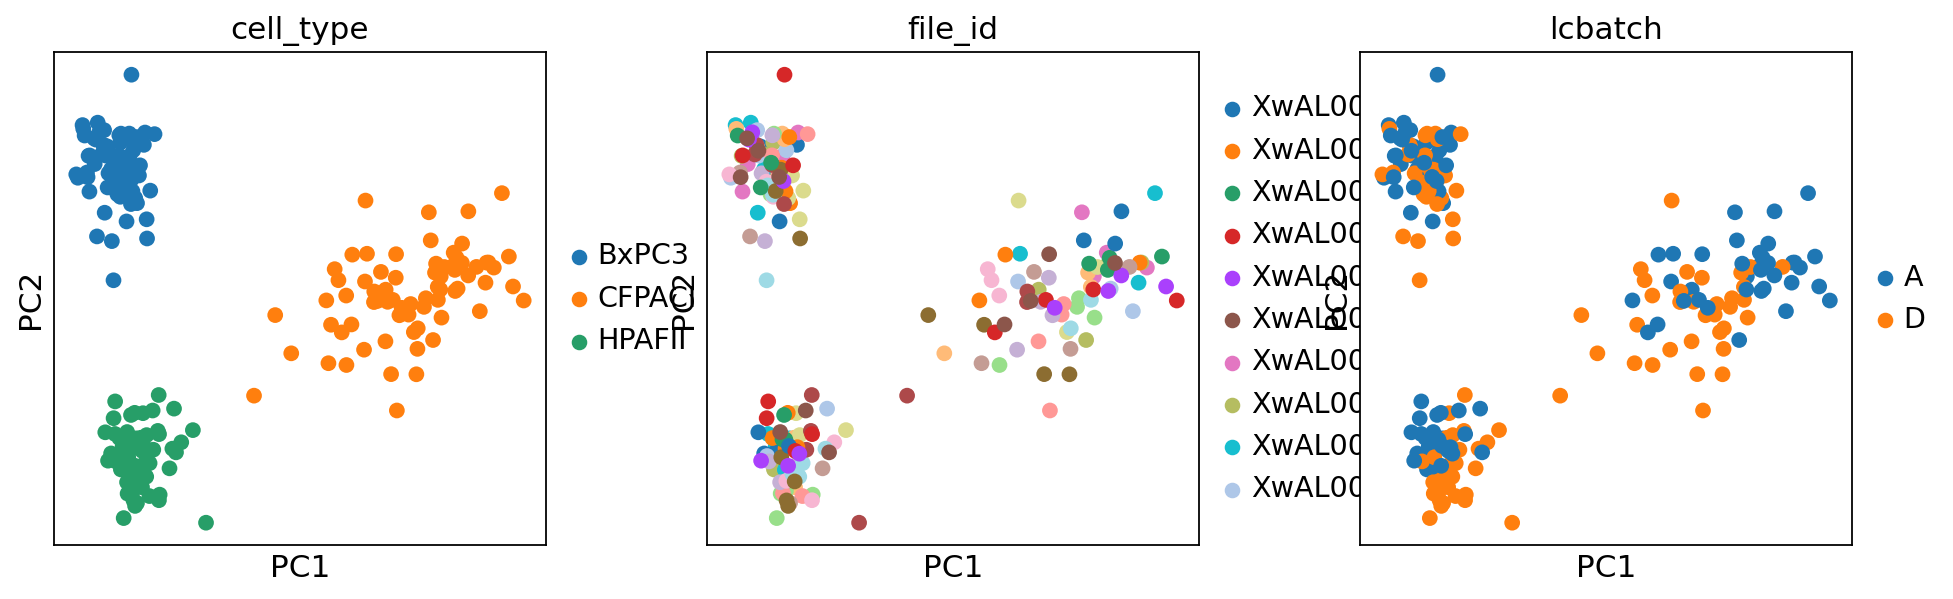

In [57]:
adata = sc.read("data/processed/pSCoPE_huffman.h5ad")

sc.pl.pca(adata, color=["cell_type", "file_id", "lcbatch"], size=200)

Data used by scPROTEIN:

In [58]:
adata = sc.read("../data_integration/integration_dataset/pSCoPE_Huffman.h5ad")

adata

AnnData object with n_obs × n_vars = 206 × 1659
    obs: 'cell_type'

/home/rasmus/sollertis/work/ra/protvi/scPROTEIN/.conda/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


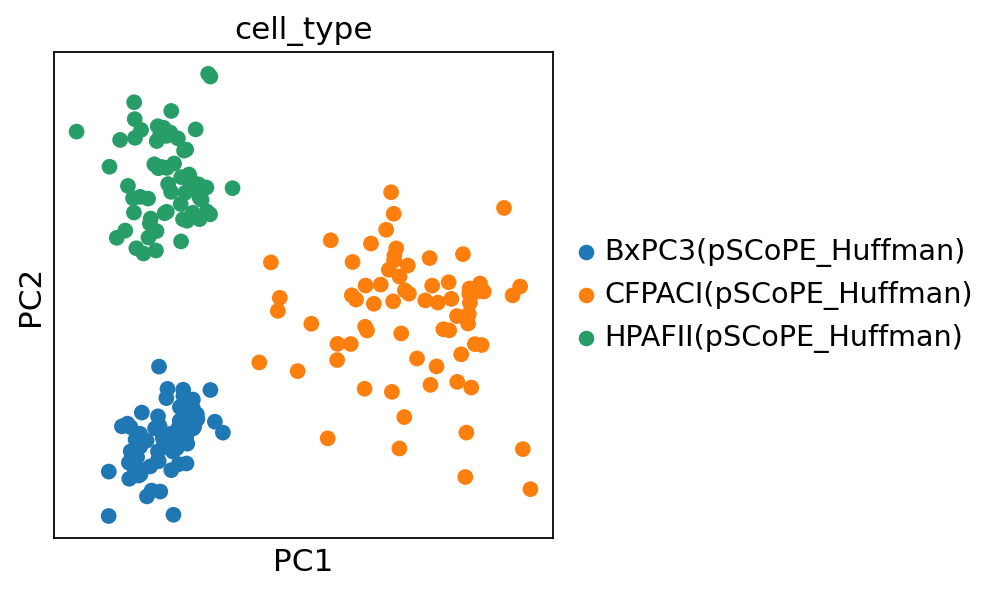

In [59]:
adata.X[np.isnan(adata.X)] = 0

sc.tl.pca(adata)
sc.pl.pca(adata, color=["cell_type"], size=200)

## pSCoPE leduc ❌

Only the preprocessed protein data contains batch and cell type. Data is available here [https://genomebiology.biomedcentral.com/articles/10.1186/s13059-022-02817-5#Sec49](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-022-02817-5#Sec49) (and here [https://scp.slavovlab.net/Leduc_et_al_2022](https://scp.slavovlab.net/Leduc_et_al_2022)).

Annotations:

- ❌ Cell type

- ❌ Batch

Here is the data used by scPROTEIN:

In [60]:
adata = sc.read("../data_integration/integration_dataset/pSCoPE_Leduc.h5ad")

adata

AnnData object with n_obs × n_vars = 1543 × 2844
    obs: 'cell_type'

/home/rasmus/sollertis/work/ra/protvi/scPROTEIN/.conda/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


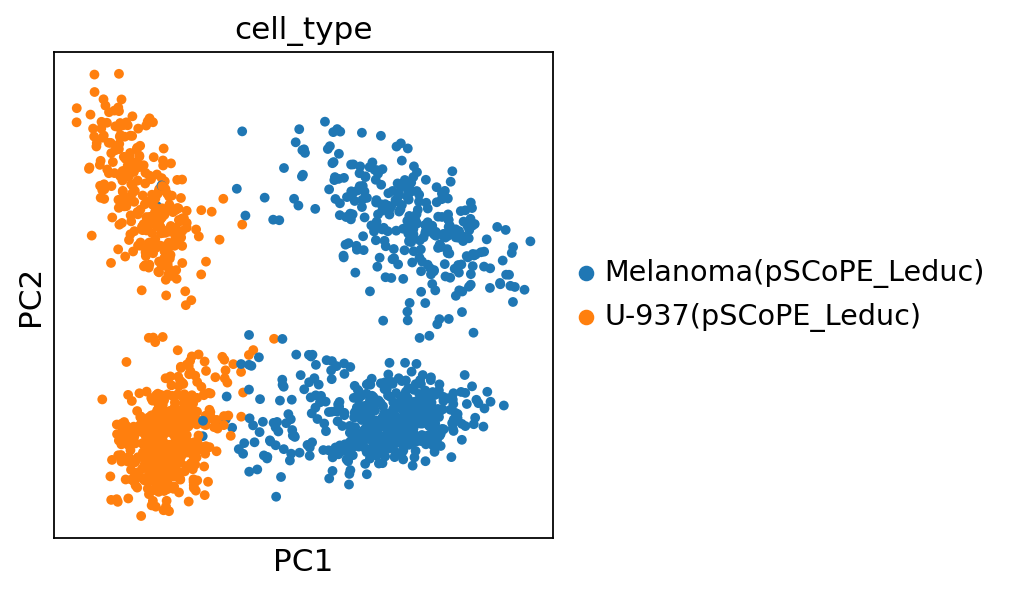

In [61]:
adata.X[np.isnan(adata.X)] = 0

sc.tl.pca(adata)
sc.pl.pca(adata, color=["cell_type"])